# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import module

In [2]:
os.getcwd()

'c:\\Users\\Pierrick\\OneDrive\\Bureau\\K\\2_MS_TelecomParis\\Cours\\Projet_Fil_Rouge\\Activity_Detection_From_Electrical_Consumption_Load_Curves\\Exploratory Data Analysis'

In [146]:
# we load house 1
house1_power_blk2 = module.load_dataset('data/house1_power_blk2_labels.zip')

# we load house 2
house2_power_blk1 = module.load_dataset('data/house2_power_blk1_labels.zip')

In [4]:
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [5]:
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


# Analysis

### EDA df_house

1. Infos sur la dataframe<br>
    a. Nombre de lignes<br>
    b. Nombre de jours, premier jour, dernier jour<br>
    c. Proportion d'activité<br>
    d. Périodes d'activité<br>
        d.1 Nombre de périodes moyen par jour<br>
        d.2 Durée moyenne d'une période activité et non activité<br>

2. Affichage<br>
    a. Activité / non activité pour des jours aléatoires<br>
    b. Swarmplot (ou BoxPlot/ViolinPlot) des durées de périodes d'activité<br>
    c. Nombre de périodes d'activité par jour au fil du temps

#### Fonctions

In [6]:
def activity_ratio(df_house):
    activity, counts = np.unique(df_house['activity'], return_counts = True)
    return (counts[np.where(activity == 1)[0]] / np.sum(counts))[0]

In [7]:
def detect_stages(house):
    """
    Transforme une dataframe de time series en une dataframe des périodes
    Args :
        -df_house : dataframe avec index datetime et une colonne activity
    Return :
        - df_stages : dataframe avec pour chaque ligne une période : (début, fin, durée, activity)
    """
    df_house=house.copy()
    df_house["next_activity"] = df_house["activity"].shift(1)
    df_house["next_activity"]=df_house["next_activity"].fillna(method="bfill").astype(int)
    df_house["switch_activityLvl"] = np.where(df_house["next_activity"]==df_house["activity"], 0, 1)
    df_house["stage"]=df_house["switch_activityLvl"].cumsum()
    df_house=df_house.reset_index().groupby(by='stage').agg({"activity" : ['mean'], "datetime": ['min', 'max']})
    df_house.columns = ['_'.join(col) for col in df_house.columns.values]
    df_house=df_house.rename(columns={"activity_mean": "activity"})
    df_house["activity"]=df_house["activity"].astype(int)
    df_house["duration_min"]=(df_house["datetime_max"]-df_house["datetime_min"]).astype("timedelta64[m]")
    df_house["duration_sec"]=(df_house["datetime_max"]-df_house["datetime_min"]).astype("timedelta64[s]")
    return df_house

#### Plots

In [8]:
# Choose dataframe
df_house = house1_power_blk2

Nombre de lignes dans la dataframe :  5439600
Pourcentage d'activité :  0.4765852268549158
Premier jour : 2016-03-06,  dernier jour : 2016-05-07, durée : 62 jours


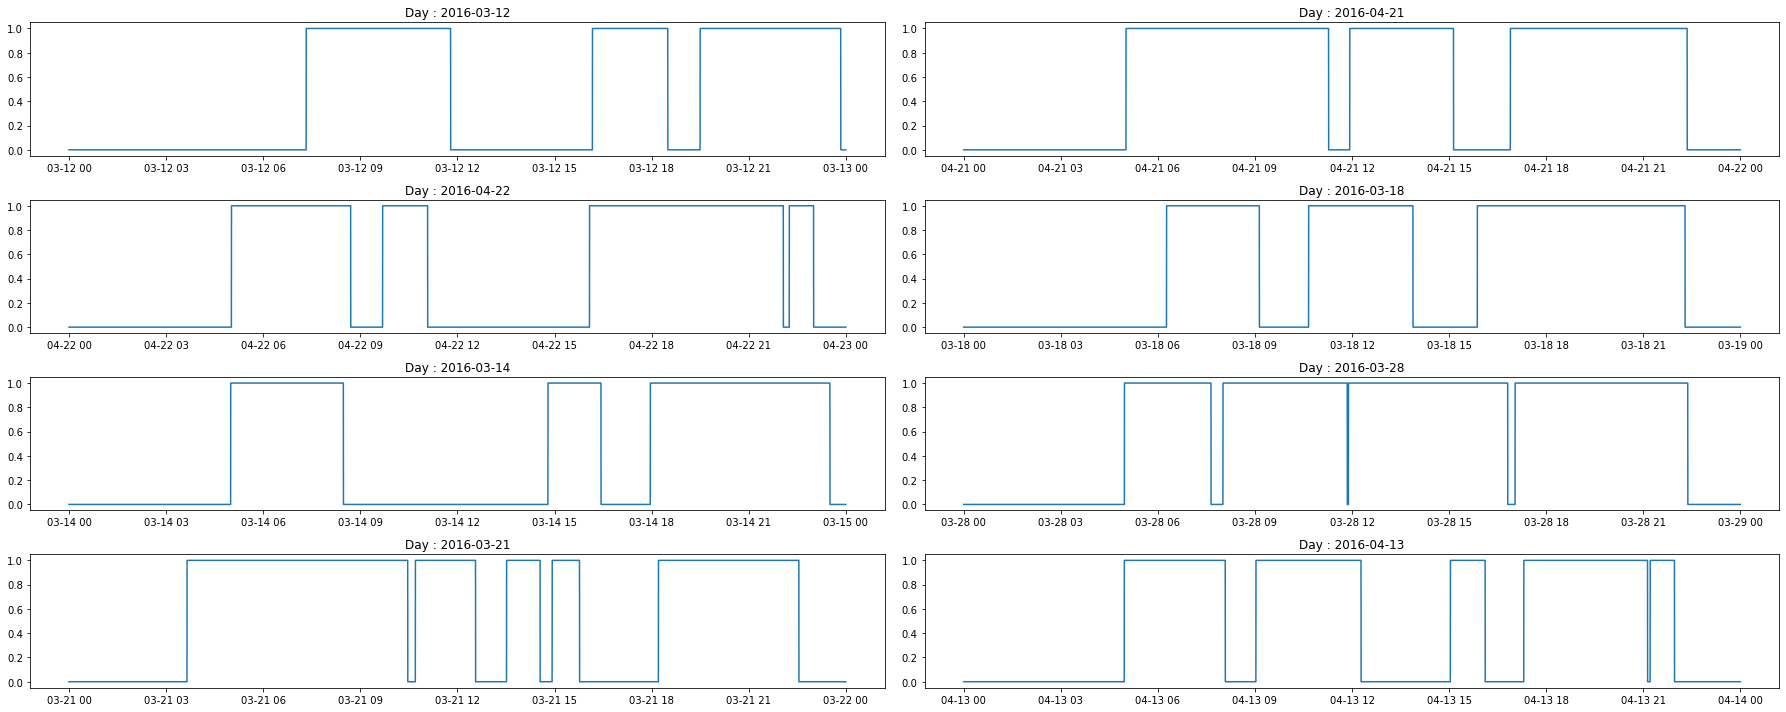

In [9]:
print("Nombre de lignes dans la dataframe : ", len(df_house))
print("Pourcentage d'activité : ", activity_ratio(df_house))
print("Premier jour : {},  dernier jour : {}, durée : {} jours".format(min(df_house.index.date), max(df_house.index.date), (max(df_house.index)- min(df_house.index)).days))

fig, ax = plt.subplots(4,2)
fig.set_size_inches((25,10))
for i in range(4):
    for j in range(2):
        random_day = df_house.sample(1).index.date[0]
        ax[i, j].plot(df_house[df_house.index.date == random_day].index, df_house[df_house.index.date == random_day]["activity"])
        ax[i, j].set_title("Day : " + str(random_day))
fig.tight_layout()

,activity,datetime_min,datetime_max,duration_min,duration_sec
stage,,,,,
0,0,2016-03-06 00:00:00,2016-03-06 06:41:40,401.0,24100.0
1,1,2016-03-06 06:41:41,2016-03-06 08:46:49,125.0,7508.0


Nombre de périodes : 501 dont 250 d'activité et 251 d'inactivité
Nombre moyen de périodes d'activité par jour :  4.03
Durée moyenne d'une période d'activité : 172.344 , écart-type : 121.23723658239886
Durée moyenne d'une période d'inactivité : 188.52988047808765 , écart-type : 170.16150593946222


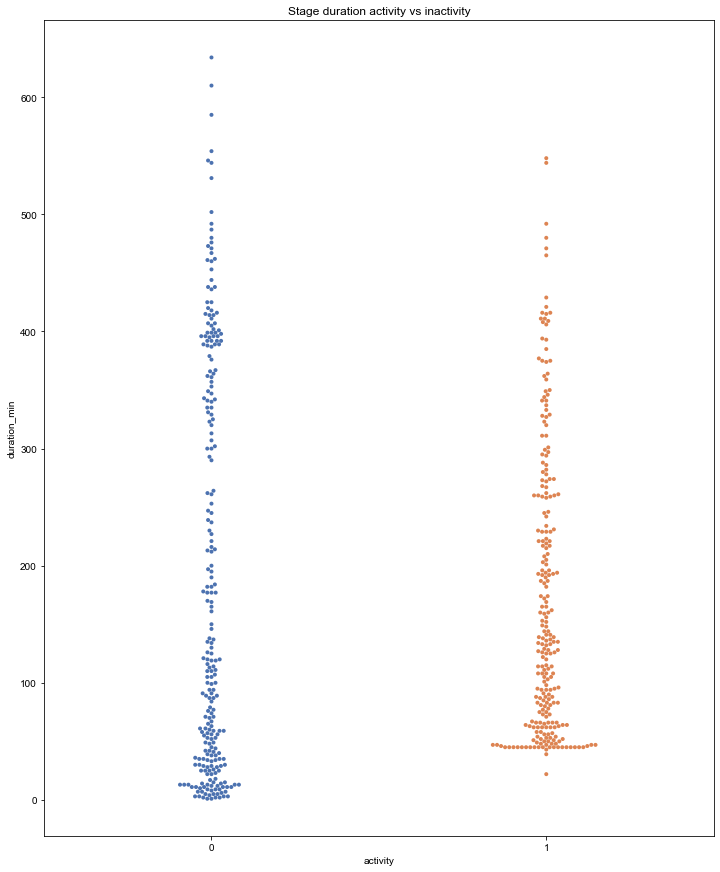

In [10]:
fig, ax = plt.subplots(figsize=(12,15))
df = detect_stages(df_house)
display(df.head(2))
sns.set_theme(style="whitegrid")
ax = sns.swarmplot(x=df["activity"], y=df['duration_min'], size=4)
ax.set_title("Stage duration activity vs inactivity")
print("Nombre de périodes : {} dont {} d'activité et {} d'inactivité".format(len(df),len(df[df["activity"]==1]), len(df[df["activity"]==0])))
print("Nombre moyen de périodes d'activité par jour : ", round(len(df[df["activity"]==1])/(max(df.datetime_max)- min(df.datetime_min)).days, 2))
print("Durée moyenne d'une période d'activité : {} , écart-type : {}".format(df[df["activity"]==1]["duration_min"].mean(), df[df["activity"]==1]["duration_min"].std()))
print("Durée moyenne d'une période d'inactivité : {} , écart-type : {}".format(df[df["activity"]==0]["duration_min"].mean(), df[df["activity"]==0]["duration_min"].std()))
del df

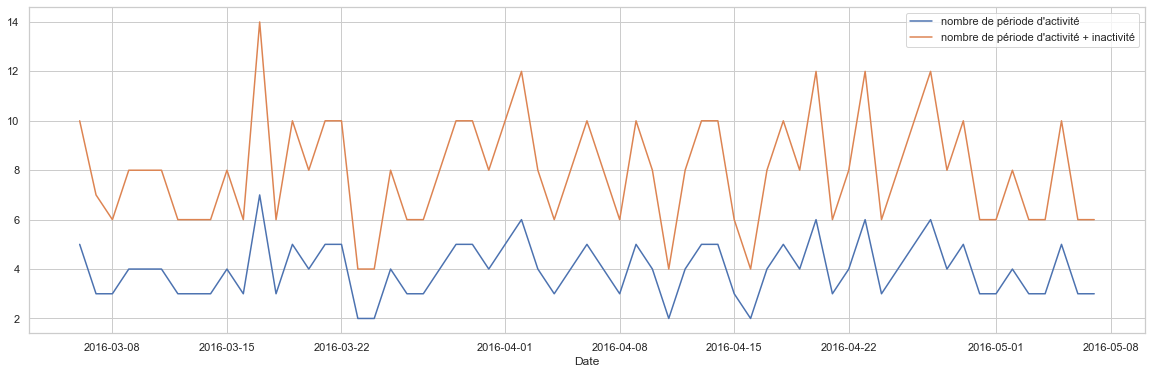

In [11]:
df = detect_stages(df_house)
df["date"] = df["datetime_min"].dt.date

df = df.groupby('date').agg({"activity" : ["count", "sum"]})
plt.figure(figsize=(20,6))
plt.plot(df.index, df["activity"]["sum"], label = "nombre de période d'activité")
plt.plot(df.index, df["activity"]["count"], label = "nombre de période d'activité + inactivité")
plt.legend()
plt.xlabel("Date")
del df

In [12]:
del df_house

# Model

Découper une dataframe en période de temps -> utiliser df.cut()<br> 
Sous échantilloner si besoin pour accélérer les calculs -> utiliser df.resample()<br>
Régression ou classification : label soit %activité sur la période, soit 0/1<br>

In [13]:
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [14]:
duration=5*60
df_house = house1_power_blk2

date_inf = min(df_house.index)

In [15]:
date_inf

Timestamp('2016-03-06 00:00:00', freq='S')

In [16]:
date_sup = date_inf + datetime.timedelta(seconds = duration)
date_sup

Timestamp('2016-03-06 00:05:00', freq='S')

In [17]:
house1_power_blk2.head() 

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [159]:
df_house = house1_power_blk2.copy()

In [160]:
df_house.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [161]:
house1_power_blk2[:9].index

DatetimeIndex(['2016-03-06 00:00:00', '2016-03-06 00:00:01',
               '2016-03-06 00:00:02', '2016-03-06 00:00:03',
               '2016-03-06 00:00:04', '2016-03-06 00:00:05',
               '2016-03-06 00:00:06', '2016-03-06 00:00:07',
               '2016-03-06 00:00:08'],
              dtype='datetime64[ns]', name='datetime', freq='S')

In [162]:
timeframes = [(datetime.time(22,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))]

In [163]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

start = datetime.time(23, 0, 0)
end = datetime.time(1, 0, 0)
time_in_range(start, end, datetime.time(23, 30, 0))
time_in_range(start, end, datetime.time(0, 30, 0))

True

In [164]:
time_in_range(*timeframes[0], house1_power_blk2[:9].index.time[0])

True

In [165]:
df_house[:9].index.time

array([datetime.time(0, 0), datetime.time(0, 0, 1),
       datetime.time(0, 0, 2), datetime.time(0, 0, 3),
       datetime.time(0, 0, 4), datetime.time(0, 0, 5),
       datetime.time(0, 0, 6), datetime.time(0, 0, 7),
       datetime.time(0, 0, 8)], dtype=object)

In [166]:
df_house["timeframe_of_interest"] = df_house.index.map(lambda x : time_in_range(*timeframes[0], x.time()))

In [167]:
df_house.head()

,mains,activity,hour,timeframe_of_interest
datetime,,,,
2016-03-06 00:00:00,473.0,0,0.0,True
2016-03-06 00:00:01,474.0,0,0.0,True
2016-03-06 00:00:02,476.0,0,0.0,True
2016-03-06 00:00:03,476.0,0,0.0,True
2016-03-06 00:00:04,475.0,0,0.0,True


In [168]:
df_house["next_toi"] = df_house["timeframe_of_interest"].shift(1)
df_house["next_toi"]=df_house["next_toi"].fillna(method='bfill')
df_house["beginning_of_toi"] = np.where(df_house["timeframe_of_interest"]==df_house["next_toi"], 0, 1)

In [169]:
print(np.unique(df_house['beginning_of_toi'], return_counts = True))
df_house.head()

(array([0, 1]), array([5439474,     126], dtype=int64))


,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi
datetime,,,,,,
2016-03-06 00:00:00,473.0,0,0.0,True,True,0
2016-03-06 00:00:01,474.0,0,0.0,True,True,0
2016-03-06 00:00:02,476.0,0,0.0,True,True,0
2016-03-06 00:00:03,476.0,0,0.0,True,True,0
2016-03-06 00:00:04,475.0,0,0.0,True,True,0


In [170]:
df_house["timeframe_id"] = df_house['beginning_of_toi'].cumsum()
df_house

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-06 00:00:00,473.0,0,0.000000,True,True,0,0
2016-03-06 00:00:01,474.0,0,0.000000,True,True,0,0
2016-03-06 00:00:02,476.0,0,0.000000,True,True,0,0
2016-03-06 00:00:03,476.0,0,0.000000,True,True,0,0
2016-03-06 00:00:04,475.0,0,0.000000,True,True,0,0
...,...,...,...,...,...,...,...
2016-05-07 22:59:55,604.0,0,22.983333,True,True,0,126
2016-05-07 22:59:56,602.0,0,22.983333,True,True,0,126
2016-05-07 22:59:57,602.0,0,22.983333,True,True,0,126


In [171]:
df_house[(df_house["timeframe_of_interest"])&(df_house["timeframe_id"]==2)]

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-06 22:00:00,1223.0,1,22.000000,True,False,1,2
2016-03-06 22:00:01,1212.0,1,22.000000,True,True,0,2
2016-03-06 22:00:02,1233.0,1,22.000000,True,True,0,2
2016-03-06 22:00:03,1210.0,1,22.000000,True,True,0,2
2016-03-06 22:00:04,1209.0,1,22.000000,True,True,0,2
...,...,...,...,...,...,...,...
2016-03-07 05:59:56,4546.0,1,5.983333,True,True,0,2
2016-03-07 05:59:57,4539.0,1,5.983333,True,True,0,2
2016-03-07 05:59:58,4550.0,1,5.983333,True,True,0,2


In [172]:
df_house[df_house["timeframe_of_interest"]]

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-06 00:00:00,473.0,0,0.000000,True,True,0,0
2016-03-06 00:00:01,474.0,0,0.000000,True,True,0,0
2016-03-06 00:00:02,476.0,0,0.000000,True,True,0,0
2016-03-06 00:00:03,476.0,0,0.000000,True,True,0,0
2016-03-06 00:00:04,475.0,0,0.000000,True,True,0,0
...,...,...,...,...,...,...,...
2016-05-07 22:59:55,604.0,0,22.983333,True,True,0,126
2016-05-07 22:59:56,602.0,0,22.983333,True,True,0,126
2016-05-07 22:59:57,602.0,0,22.983333,True,True,0,126


In [180]:
list(df_house[df_house["timeframe_of_interest"]].groupby(["timeframe_id"]).groups.keys())

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126]

In [174]:
group_0 = df_house[df_house["timeframe_of_interest"]].groupby(["timeframe_id"]).groups[2]
group_0

DatetimeIndex(['2016-03-06 22:00:00', '2016-03-06 22:00:01',
               '2016-03-06 22:00:02', '2016-03-06 22:00:03',
               '2016-03-06 22:00:04', '2016-03-06 22:00:05',
               '2016-03-06 22:00:06', '2016-03-06 22:00:07',
               '2016-03-06 22:00:08', '2016-03-06 22:00:09',
               ...
               '2016-03-07 05:59:51', '2016-03-07 05:59:52',
               '2016-03-07 05:59:53', '2016-03-07 05:59:54',
               '2016-03-07 05:59:55', '2016-03-07 05:59:56',
               '2016-03-07 05:59:57', '2016-03-07 05:59:58',
               '2016-03-07 05:59:59', '2016-03-07 06:00:00'],
              dtype='datetime64[ns]', name='datetime', length=28801, freq=None)

In [253]:
df_house.loc[group_0]

KeyboardInterrupt: 

In [238]:
def time_in_range(start, end, x):
        """Return true if x is in the range [start, end]"""
        if start <= end:
            return start <= x <= end
        else:
            return start <= x or x <= end
            
def segmentDf(df, timeframes, use_labels=False):
    """
    Transforme df_house en une liste de datframe filtrée selon les périodes définies dans timeframes
    Args:
        - df_house : dataframe avec une colonne mains indiquant la puissance instantannée et la datetime en index
        - timeframes : liste de tuples indiquant les périodes de la journée ex : timeframes = [(datetime.time(10,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))]
    Returns :
        - DataFrame :
            - index : datetime de la time series
            - mains	: puissance
            - activity : 1/0 selon labellisation effectuée en amont
            - hour	: heure de la journée
            - timeframe_of_interest	 : True/False si la période est à utiliser selon timeframe
            - next_toi : même colonne que timeframe_of_interest décalée de 1 (pour construction des ranges)
            - beginning_of_toi	: début d'une période
            - timeframe_id : numéro de période
    """
    l_res = []
    df_house = df.copy()
    for i in range(len(timeframes)):
        df_house.loc[:, "timeframe_of_interest"] = df_house.index.map(lambda x : time_in_range(*timeframes[i], x.time())) # modifier timeframes pour itérer
        
        df_house.loc[:, "next_toi"] = df_house.loc[:,"timeframe_of_interest"].shift(1)
        df_house.loc[:,"next_toi"]= df_house.loc[:,"next_toi"].fillna(method='bfill')
        df_house.loc[:,"beginning_of_toi"] = np.where(df_house.loc[:,"timeframe_of_interest"]==df_house.loc[:,"next_toi"], 0, 1)

        df_house.loc[:,"timeframe_id"] = df_house.loc[:,'beginning_of_toi'].cumsum()

        groupby_object = df_house[df_house["timeframe_of_interest"]].groupby(["timeframe_id"])
        
        
        for key in list(groupby_object.groups.keys()):
            print(key)
            l_res.append(df_house.loc[df_house[df_house["timeframe_of_interest"]].groupby(["timeframe_id"]).groups[key]])
        
    return l_res

In [237]:
timeframes

[(datetime.time(22, 0), datetime.time(6, 0)),
 (datetime.time(12, 0), datetime.time(13, 0))]

In [239]:
df_house = house1_power_blk2.copy()

In [240]:
df_house.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [241]:
timeframes

[(datetime.time(22, 0), datetime.time(6, 0)),
 (datetime.time(12, 0), datetime.time(13, 0))]

In [247]:
l_res = segmentDf(df_house.iloc[:500000], timeframes, use_labels=False)

0
2
4
6
8
10
1
3
5
7
9
11


In [248]:
len(l_res)

12

In [249]:
l_res[0]

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-06 00:00:00,473.0,0,0.000000,True,True,0,0
2016-03-06 00:00:01,474.0,0,0.000000,True,True,0,0
2016-03-06 00:00:02,476.0,0,0.000000,True,True,0,0
2016-03-06 00:00:03,476.0,0,0.000000,True,True,0,0
2016-03-06 00:00:04,475.0,0,0.000000,True,True,0,0
...,...,...,...,...,...,...,...
2016-03-06 05:59:56,2412.0,0,5.983333,True,True,0,0
2016-03-06 05:59:57,2413.0,0,5.983333,True,True,0,0
2016-03-06 05:59:58,2404.0,0,5.983333,True,True,0,0


In [250]:
l_res[1]

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-06 22:00:00,1223.0,1,22.000000,True,False,1,2
2016-03-06 22:00:01,1212.0,1,22.000000,True,True,0,2
2016-03-06 22:00:02,1233.0,1,22.000000,True,True,0,2
2016-03-06 22:00:03,1210.0,1,22.000000,True,True,0,2
2016-03-06 22:00:04,1209.0,1,22.000000,True,True,0,2
...,...,...,...,...,...,...,...
2016-03-07 05:59:56,4546.0,1,5.983333,True,True,0,2
2016-03-07 05:59:57,4539.0,1,5.983333,True,True,0,2
2016-03-07 05:59:58,4550.0,1,5.983333,True,True,0,2


In [251]:
l_res[2]

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-07 22:00:00,513.0,1,22.000000,True,False,1,4
2016-03-07 22:00:01,518.0,1,22.000000,True,True,0,4
2016-03-07 22:00:02,516.0,1,22.000000,True,True,0,4
2016-03-07 22:00:03,511.0,1,22.000000,True,True,0,4
2016-03-07 22:00:04,514.0,1,22.000000,True,True,0,4
...,...,...,...,...,...,...,...
2016-03-08 05:59:56,2962.0,1,5.983333,True,True,0,4
2016-03-08 05:59:57,2965.0,1,5.983333,True,True,0,4
2016-03-08 05:59:58,2963.0,1,5.983333,True,True,0,4


In [252]:
l_res[8]

,mains,activity,hour,timeframe_of_interest,next_toi,beginning_of_toi,timeframe_id
datetime,,,,,,,
2016-03-08 12:00:00,2388.0,0,12.000000,True,False,1,5
2016-03-08 12:00:01,2390.0,0,12.000000,True,True,0,5
2016-03-08 12:00:02,2393.0,0,12.000000,True,True,0,5
2016-03-08 12:00:03,2387.0,0,12.000000,True,True,0,5
2016-03-08 12:00:04,2386.0,0,12.000000,True,True,0,5
...,...,...,...,...,...,...,...
2016-03-08 12:59:56,2777.0,0,12.983333,True,True,0,5
2016-03-08 12:59:57,2774.0,0,12.983333,True,True,0,5
2016-03-08 12:59:58,2779.0,0,12.983333,True,True,0,5
